# GAN1_U-net + critic(Softmax)

## Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = Path('data/smokeGAN')

folder = 'targets'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

folder = 'crappy'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
path.ls()

path_hr = path/'targets'
path_lr = path/'crappy'

## Crappified data

Prepare the input data by crappifying images.

parallel compute

In [3]:
from PIL import Image, ImageDraw, ImageFont

In [4]:
class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,90)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [5]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

For gradual resizing we can change the commented line here.

In [6]:
# bs,size=32, 128
# bs,size = 24,160
# bs,size = 16,256
bs, size = 8, 256
arch = models.resnet34  # the batch size is for suiting GPU,

## Pre-train generator

Now let's pretrain the generator.

In [7]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [8]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=1.05, flip_vert=True, max_lighting=0.1, max_warp=0.), size=size, tfm_y=True) # some transform to data augmentation
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True)) # imegenet_stats to pre_train

    data.c = 3
    return data

In [9]:
data_gen = get_data(bs,size)

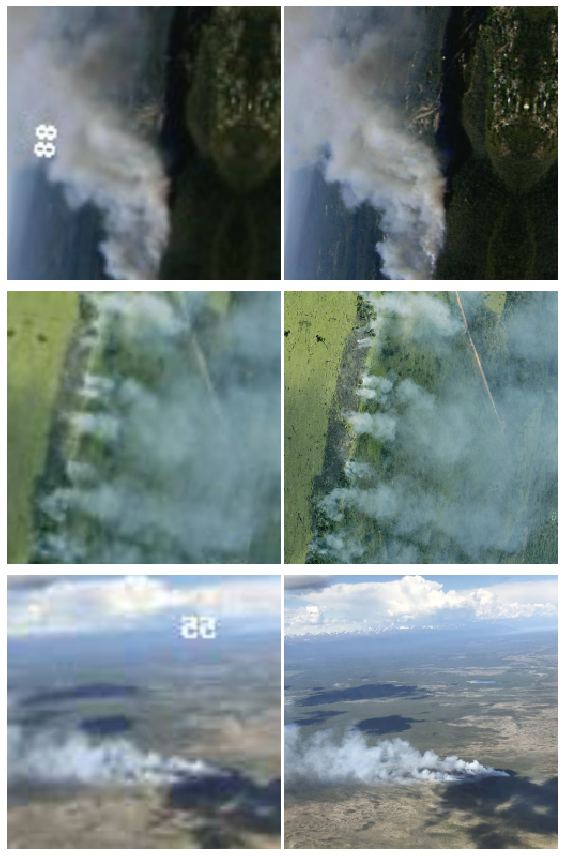

In [10]:
data_gen.show_batch(3) # the crapped images and the terget images. They are crapped by the function crappifier above

In [11]:
wd = 1e-3

In [12]:
y_range = (-3.,3.)

In [13]:
loss_gen = MSELossFlat()

In [14]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [15]:
learn_gen = create_gen_learner()

In [16]:
# lr_find(learn_gen)
# learn_gen.recorder.plot()

In [17]:
learn_gen.fit_one_cycle(7, pct_start=0.8) # when adding images, batches increased, the training cycle need to increase, and we found that at somewhere the losses are chattering going down.

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [ ]:
learn_gen.recorder.plot_losses()

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(6, slice(1e-6,1e-3))

In [ ]:
learn_gen.recorder.plot_losses() # maybe a little over trained because the train loss is smaller??? However, it obviously jumped from the local minimum, whether it is good or bad??? hard to say

In [ ]:
learn_gen.show_results(rows=3)

In [ ]:
learn_gen.save('gen-pre2')

## Save generated images

In [65]:
learn_gen.load('gen-pre2');

In [27]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [28]:
# shutil.rmtree(path_gen)

In [29]:
path_gen.mkdir(exist_ok=True)

In [30]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [ ]:
save_preds(data_gen.fix_dl)

In [ ]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [31]:
learn_gen=None
learn_critic = None
gc.collect()

116

In [32]:
bs, size = 8, 256

In [33]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=1.05, flip_vert=True, max_lighting=0.1, max_warp=0.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [34]:
data_crit = get_crit_data([name_gen, 'targets'], bs=bs, size=size)

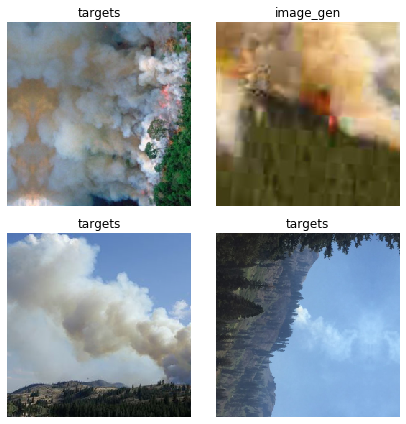

In [35]:
data_crit.show_batch(rows=2, ds_type=DatasetType.Train, imgsize=3)

In [36]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [37]:
def create_critic_learner(data, metrics): 
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd) # the model here should be something which uses the spectral normalization

In [38]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
lr_find(learn_critic)
learn_critic.recorder.plot() # working???

In [ ]:
lr_critic = 1e-3 #lowest point/10

In [ ]:
learn_critic.fit_one_cycle(3, lr_critic)

In [ ]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [52]:
learn_crit=None
learn_gen=None
gc.collect()

165

In [53]:
bs, size = 8, 256

In [54]:
data_crit = get_crit_data(['crappy', 'targets'], bs=bs, size=size)

In [55]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [56]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects for the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5, then switch one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [57]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [45]:
lr = 1e-3

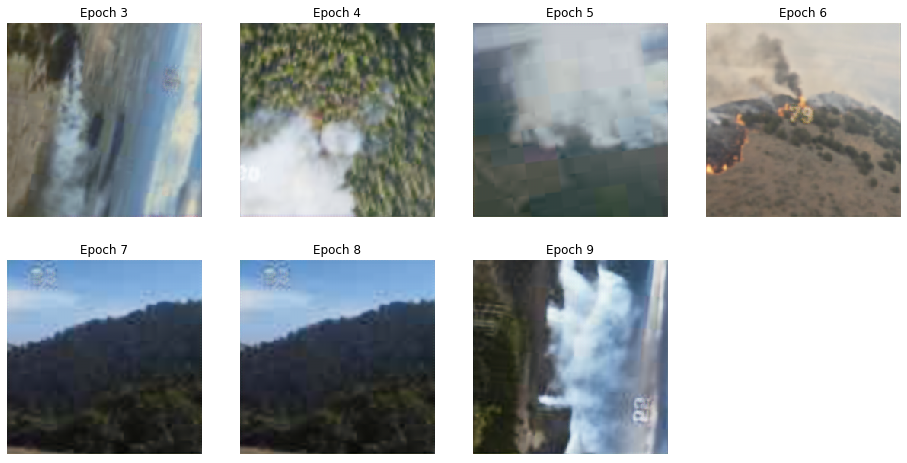

In [46]:
learn.fit(10,lr)

In [47]:
learn.save('gan-1c')

In [58]:
# learn.data=get_data(16,192)
learn.data=get_data(4,256)

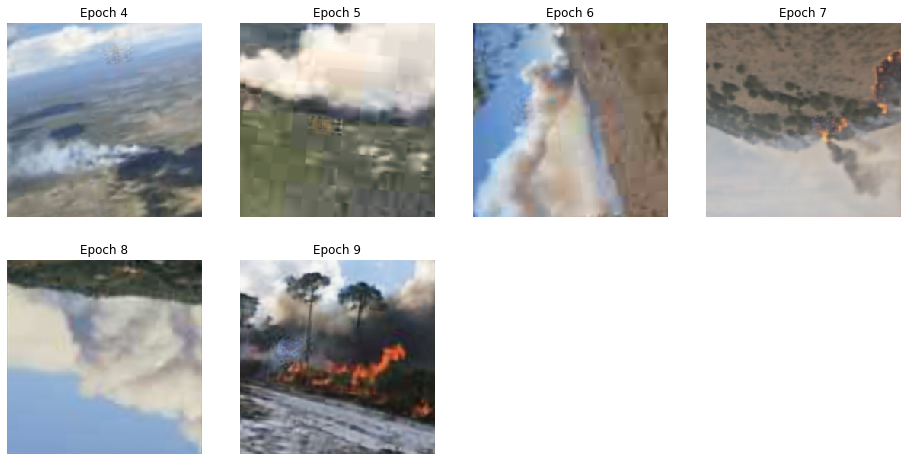

AttributeError: 'NoneType' object has no attribute 'to_fp16'

In [59]:
gc.collect()
learn.fit(10,lr/2)

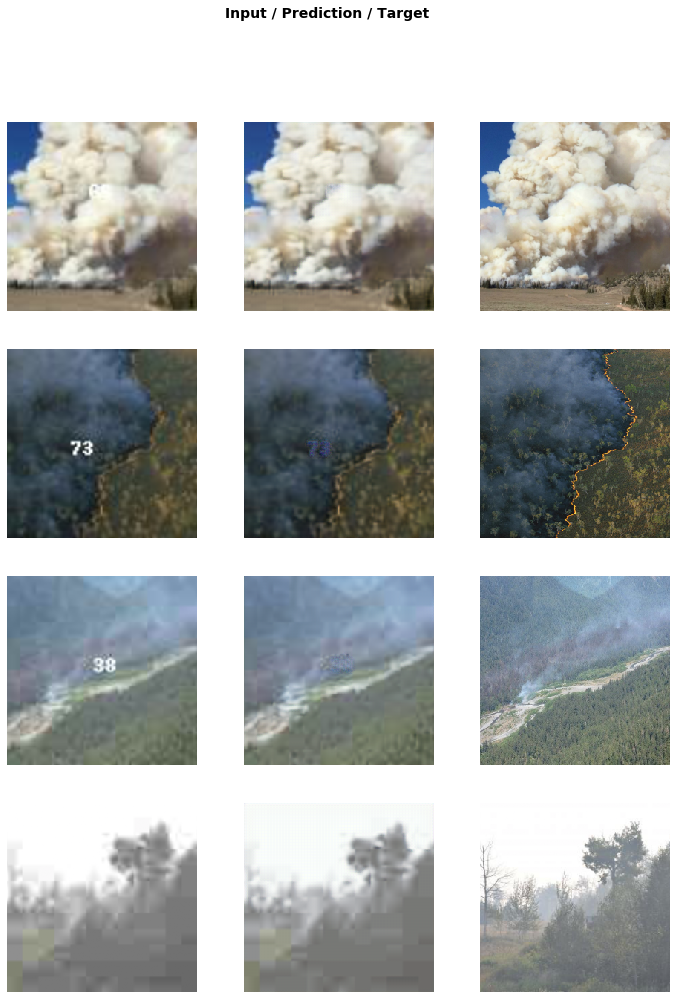

In [60]:
learn.show_results(rows=5)

In [69]:
learn.save('gan-2c')

## Preparing Turn To GAN2

In [73]:
learn.load('gan-2c')

GANLearner(data=ImageDataBunch;

Train: LabelList (178 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: data/smokeGAN/crappy;

Valid: LabelList (19 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: data/smokeGAN/crappy;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1

In [79]:
name_GAN = 'image_GAN'
path_GAN = path/name_GAN
path_GAN.mkdir(exist_ok=True)

In [80]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_GAN/names[i].name)
            i += 1

In [84]:
save_preds(data_gen.fix_dl)

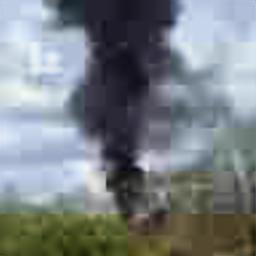

In [83]:
PIL.Image.open(path_GAN.ls()[0])